# 1 

A partir del fichero "US_Crime_Rates_1960_2014", se pide:

1. Tratar el dataset como una serie temporal a partir de la columna Year. Siempre el eje X será el nuevo índice Year.
2. Dibujar todas las columnas numéricas.
3. Como se puede ver en el punto 2, la columna "Population" tiene una magnitud diferente a la de las demás columnas: Dibuja la misma gráfica que antes pero con dos resoluciones diferentes para que se puedan observar con mejor detalle todas las columnas. 
4. A partir de ahora y para el resto del ejercicio, borra las columnas "Population" y "Total" ¿Qué columnas tienen mejor correlación? 
5. A partir de las cinco columnas que tengan mejor correlación con la columna "Murder", entrena un modelo de regresión no lineal a partir de polinomio de grado 6. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento.
6. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones = 23 y batches = 7.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.model_selection import train_test_split, RepeatedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error

Vehicle_Theft       Vehicle_Theft         1.000000
Larceny_Theft       Larceny_Theft         1.000000
Property            Property              1.000000
Murder              Murder                1.000000
Forcible_Rape       Forcible_Rape         1.000000
                                            ...   
Violent             Burglary              0.646607
Burglary            Forcible_Rape         0.588529
Forcible_Rape       Burglary              0.588529
Burglary            Aggravated_assault    0.498449
Aggravated_assault  Burglary              0.498449
Length: 81, dtype: float64

<AxesSubplot:xlabel='Year'>

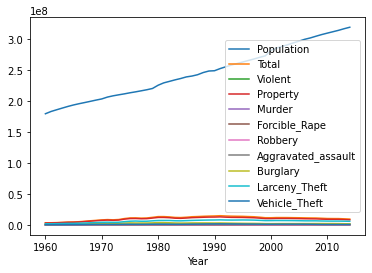

In [3]:
import pandas as pd
df = pd.read_csv("data/US_Crime_Rates_1960_2014.csv")

df.set_index("Year", inplace=True)
df.plot()

In [4]:
df.head()

,Population,Total,Violent,Property,Murder,Forcible_Rape,Robbery,Aggravated_assault,Burglary,Larceny_Theft,Vehicle_Theft
Year,,,,,,,,,,,
1960,179323175,3384200,288460,3095700,9110,17190,107840,154320,912100,1855400,328200
1961,182992000,3488000,289390,3198600,8740,17220,106670,156760,949600,1913000,336000
1962,185771000,3752200,301510,3450700,8530,17550,110860,164570,994300,2089600,366800
1963,188483000,4109500,316970,3792500,8640,17650,116470,174210,1086400,2297800,408300
1964,191141000,4564600,364220,4200400,9360,21420,130390,203050,1213200,2514400,472800


In [5]:
from data_mining_tb import df_info
df_info(df=df)

####
DATAFRAME INFO
####

Number of rows: 55
Number of columns: 11

#### DATAFRAME COLUMNS ####
 Index(['Population', 'Total', 'Violent', 'Property', 'Murder', 'Forcible_Rape',
       'Robbery', 'Aggravated_assault', 'Burglary', 'Larceny_Theft',
       'Vehicle_Theft'],
      dtype='object') 

### DATAFRAME COLUMN TYPES ###

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 1960 to 2014
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Population          55 non-null     int64
 1   Total               55 non-null     int64
 2   Violent             55 non-null     int64
 3   Property            55 non-null     int64
 4   Murder              55 non-null     int64
 5   Forcible_Rape       55 non-null     int64
 6   Robbery             55 non-null     int64
 7   Aggravated_assault  55 non-null     int64
 8   Burglary            55 non-null     int64
 9   Larceny_Theft       55 non-null     int64
 

## Just for fun!
- Try to normalize just 1 column to see if there's an improvement while plotting
- It is obvious that it makes no sense, but it's important to see the normalization behavior

In [6]:
new_df = df.copy()

<AxesSubplot:xlabel='Year'>

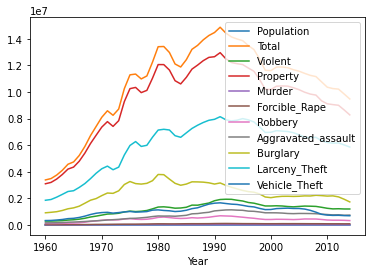

In [7]:
scaler = MinMaxScaler()
population_normalized = scaler.fit_transform(np.array(df.Population).reshape(-1, 1))
population_normalized
new_df.Population = population_normalized

new_df.plot()

In [8]:
df.drop(columns=['Population', 'Total'],inplace=True)
df.describe()

,Violent,Property,Murder,Forcible_Rape,Robbery,Aggravated_assault,Burglary,Larceny_Theft,Vehicle_Theft
count,5.500000e+01,5.500000e+01,55.000000,55.000000,55.000000,5.500000e+01,5.500000e+01,5.500000e+01,5.500000e+01
mean,1.188806e+06,9.412499e+06,17317.236364,72714.800000,416449.890909,6.811818e+05,2.424017e+06,5.959947e+06,1.028614e+06
std,4.597107e+05,2.738512e+06,4267.442664,28278.006893,150506.403782,2.960255e+05,7.259004e+05,1.846401e+06,3.455693e+05
min,2.884600e+05,3.095700e+06,8530.000000,17190.000000,106670.000000,1.543200e+05,9.121000e+05,1.855400e+06,3.282000e+05
25%,9.253150e+05,8.060014e+06,14819.000000,53400.000000,354911.500000,4.384300e+05,2.105336e+06,4.843350e+06,7.896260e+05
50%,1.322390e+06,1.018259e+07,17030.000000,84230.000000,423557.000000,7.412910e+05,2.329950e+06,6.591900e+06,1.032200e+06
75%,1.432762e+06,1.160509e+07,20561.500000,92930.000000,512137.000000,9.002150e+05,3.073600e+06,7.168450e+06,1.239302e+06
max,1.932270e+06,1.296110e+07,24700.000000,109060.000000,687730.000000,1.135610e+06,3.795200e+06,8.142200e+06,1.661700e+06


### Which columns have the best correlation?

In [9]:
corr = df.corr()
sorted_mat = corr.unstack().sort_values(ascending=False)
sorted_mat

Vehicle_Theft       Vehicle_Theft         1.000000
Larceny_Theft       Larceny_Theft         1.000000
Property            Property              1.000000
Murder              Murder                1.000000
Forcible_Rape       Forcible_Rape         1.000000
                                            ...   
Violent             Burglary              0.646607
Burglary            Forcible_Rape         0.588529
Forcible_Rape       Burglary              0.588529
Burglary            Aggravated_assault    0.498449
Aggravated_assault  Burglary              0.498449
Length: 81, dtype: float64

<AxesSubplot:>

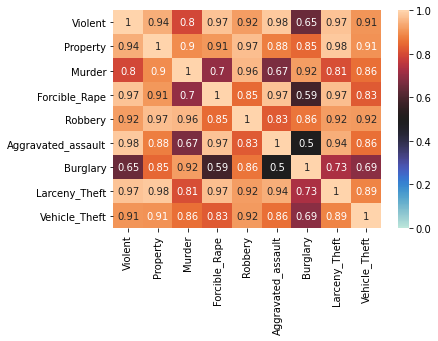

In [10]:
sns.heatmap(corr, annot=True, vmin=0, vmax=1, center= 0.5)

In [14]:
# See which columns have the highest correlations with 'Murder'
corr['Murder'].sort_values(ascending=False)[1:6]

Robbery          0.960156
Burglary         0.920207
Property         0.895641
Vehicle_Theft    0.856600
Larceny_Theft    0.806279
Name: Murder, dtype: float64

### Now that we have the top 5 columns with higher correlation with the 'Murder' columns. Let's train a non-linear model

In [15]:
# Let's iterate through the Repeated Kfold collecting the errors and the batches 

In [19]:


# X --> Features
X = df[['Robbery', 'Burglary', 'Property', 'Vehicle_Theft', 'Larceny_Theft']]
# y --> Target
y = df['Murder']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=55)


for i, (train, val) in enumerate(rkf.split(X=X_train)):
    print("ITERATION", i+1, ":")
    print(train)
    print('\nBatch size:', len(train))
    print("-------------------")
    if i == 1:
        print('##################')
# Assign the model to a variable
polynomial_f = PolynomialFeatures()
X_poly = polynomial_f.fit_transform(X_train, y_train)
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y_train)
y_pred = lin_reg.predict(X_poly)
rmse = mean_squared_error(y_train, y_pred, squared=True)
print('\ny_pred', y_pred.shape)
print('\nScore:', r2_score(y_train, y_pred), '\n')

----
ITERATION 43 :
[ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 16 17 18 19 20 24 25 26 27 28
 29 30 31 32 35 36 37 38 39 40 41 42 43]

Batch size: 37
-------------------
ITERATION 44 :
[ 1  2  3  4  5  6  7  8  9 10 11 13 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 30 32 33 34 36 38 39 40 41 42 43]

Batch size: 37
-------------------
ITERATION 45 :
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 18 19 20 21 22 23 25 26 27
 28 29 30 31 32 33 34 35 37 38 40 41 42 43]

Batch size: 38
-------------------
ITERATION 46 :
[ 0  1  2  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 43]

Batch size: 38
-------------------
ITERATION 47 :
[ 0  1  3  5  6  7  8  9 11 12 13 14 15 16 17 19 20 21 22 23 24 25 26 27
 29 30 31 33 34 35 36 37 38 39 40 41 42 43]

Batch size: 38
-------------------
ITERATION 48 :
[ 0  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 25 26
 28 29 30 31 32 33 34 35 36 37 39 40 41 42]

Batch size: 38
-------------

In [83]:
print('Cross validation r2_score: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

print('\nMax:', n_scores.max())
print('Min:', n_scores.min())

Cross validation r2_score: -752.504 (96.065)

Max: -585.1392394135567
Min: -864.2500010962831


In [20]:
plt.plot(train_score, color="b")
plt.plot(val_score, color="r")
val_score

NameError: name 'train_score' is not defined